In [14]:
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.nam import NAM
from models.dnn import DNN
from models.utils import *

from utils.plotting import *

from config.default import defaults

from trainer.trainer import Trainer
from trainer.wandbtrainer import *

from data.toydataset import ToyDataset
from data.generator import *

from typing import Sequence 
from typing import List

import matplotlib.pyplot as plt 
import numpy as np

import wandb
"""
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [11]:
%reload_ext autoreload 
%autoreload 2

In [3]:
os.getcwd()

'/scratch/work/zhangx18/reproduced-nam/mynam'

In [4]:
import shutil
shutil.rmtree('/scratch/work/zhangx18/reproduced-nam/mynam/output')

# Set up synthetic toy dataset 

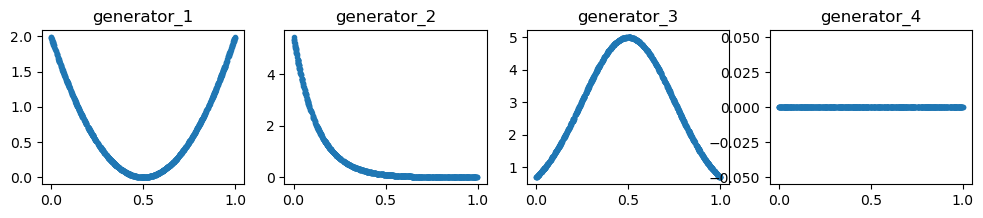

In [3]:
cfg = defaults()
gen_funcs, gen_func_names = task_4()

toydataset = ToyDataset(
    task_name="Task 1", 
    config=cfg, 
    num_samples=1000, 
    in_features=4, 
    x_start=0, 
    x_end=1, 
    gen_funcs=gen_funcs, 
    gen_func_names=gen_func_names
)
toydataset.plot()

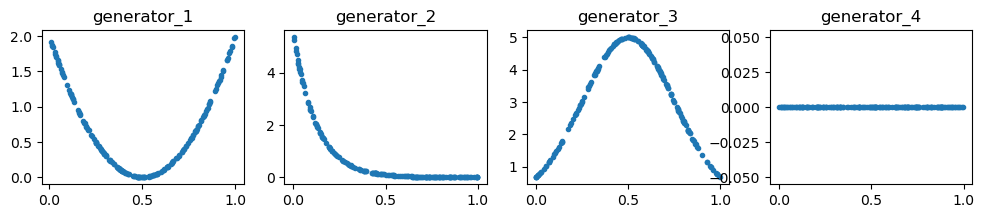

In [4]:
testset = ToyDataset(
    task_name="Task 1", 
    config=cfg, 
    num_samples=200, 
    in_features=4, 
    x_start=0, 
    x_end=1, 
    gen_funcs=gen_funcs, 
    gen_func_names=gen_func_names,
    use_test=True, 
)
testset.plot()

In [5]:
wandb.login()
wandb.finish() # mark runs as finished before starting new runs

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xinyu-zhang. Use `wandb login --relogin` to force relogin


# W&B

In [6]:
# note that non-iterative type is invalid for wandb parameters_list
# note that log_uniform will add base exponents;
# while log_uniform_values expects specified values. 
# parameters_list = {
#     'lr': {
#         'distribution': 'log_uniform_values',
#         'min': 1e-3, 
#         'max': 1e-1, 
#     }, 
#     'output_regularization': {
#         'distribution': 'log_uniform_values',
#         'min': 1e-3, 
#         'max': 1e-1, 
#     }, 
#     'l2_regularization': {
#         'distribution': 'log_uniform_values',
#         'min': 1e-6, 
#         'max': 1e-4, 
#     }, 
#     'dropout':  {
#         'values': [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#     }, 
#     'feature_dropout': {
#         'values': [0, 0.05, 0.1, 0.2]
#     }, 
#     'decay_rate':  {
#         'values': [0, 0.005]
#     }, 
#     'activation':  {
#         'values': ['relu', 'exu']
#     }, 
    
# }
parameters_list = {
    'lr': {
        'distribution': 'log_uniform_values',
        'min': 1e-3, 
        'max': 1e-2, 
    }, 
    'output_regularization': {
        'distribution': 'log_uniform_values',
        'min': 1e-3, 
        'max': 1e-2, 
    }, 
    'l2_regularization': {
        'distribution': 'log_uniform_values',
        'min': 1e-5, 
        'max': 1e-4, 
    }, 
    'dropout':  {
        'values': [0, 0.05, 0.1, 0.2]
    }, 
    'feature_dropout': {
        'values': [0, 0.05, 0.1, 0.2]
    }, 
    'decay_rate':  {
        'values': [0, 0.005]
    }, 
    'activation':  {
        'values': ['relu', 'exu']
    }, 
    
}
sweep_configuration = {
    'method': 'bayes', 
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'val_MAE', 
    }, 
    'early_terminate': {
      'type': 'hyperband', 
        'min_iter': 3,
    },
    'parameters': parameters_list
}
# initialize the sweep 
sweep_id = wandb.sweep(
    sweep=sweep_configuration, 
    project='nam-sweep-gradient'
)

print(f"sweep id: {sweep_id}")

Create sweep with ID: uqzjfkb2
Sweep URL: https://wandb.ai/xinyu-zhang/nam-sweep-gradient/sweeps/uqzjfkb2
sweep id: uqzjfkb2


In [7]:
wandb.agent(sweep_id, 
            function=partial(sweep_train, 
                             config=cfg, 
                             dataset=toydataset, 
                             testset=testset),
            count=15) # specify the maximum number of runs

wandb: Agent Starting Run: khlh0xic with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 1.53728464619536e-05
wandb: 	lr: 0.001440281088405058
wandb: 	output_regularization: 0.0014357006074594328
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.001440281088405058, l2_regularization=1.53728464619536e-05, output_regularization=0.0014357006074594328, dropout=0, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='relu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): LinearReLU(in_features=1, out_features=1024)
        (1): Dropout(p=0, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▆▅▃▂▁▁▁▁▁
train_loss,█▆▅▃▂▁▁▁▁▁
val_MAE,█▆▄▃▁▁▂▂▁▁
val_loss,█▆▄▂▁▁▂▁▁▁
epoch,9
train_MAE,2.13795
train_loss,7.46315
val_MAE,1.95069
val_loss,5.98261


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l07xgcus with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 2.9535955706638426e-05
wandb: 	lr: 0.003678123725512205
wandb: 	output_regularization: 0.0031049628494134412
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.003678123725512205, l2_regularization=2.9535955706638426e-05, output_regularization=0.0031049628494134412, dropout=0.05, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.05, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.05, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▄▃▃▂▂▂▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_MAE,▂▅█▄▁▂▂▁▁▁
val_loss,▁▅█▄▁▂▂▁▁▁
epoch,9
train_MAE,2.03514
train_loss,6.82206
val_MAE,1.79099
val_loss,5.17377


wandb: Agent Starting Run: vk3tlkzk with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 3.597569023128495e-05
wandb: 	lr: 0.0020509904590330433
wandb: 	output_regularization: 0.0018137451481386104
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.0020509904590330433, l2_regularization=3.597569023128495e-05, output_regularization=0.0018137451481386104, dropout=0, feature_dropout=0.1, num_basis_functions=1024, hidden_sizes=[], activation='relu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.1, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): LinearReLU(in_features=1, out_features=1024)
        (1): Dropout(p=0, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▅▂▁▂▁▁▁▁▁
train_loss,█▄▂▁▂▁▁▁▁▁
val_MAE,█▃▁▃▂▁▁▁▁▁
val_loss,█▃▁▃▂▁▁▁▁▁
epoch,9
train_MAE,1.94397
train_loss,6.20793
val_MAE,1.9274
val_loss,5.712


wandb: Agent Starting Run: if2svasg with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 3.126417099814211e-05
wandb: 	lr: 0.0042602339229247405
wandb: 	output_regularization: 0.0050391788447507
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.0042602339229247405, l2_regularization=3.126417099814211e-05, output_regularization=0.0050391788447507, dropout=0.1, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▃▃▂▂▂▂▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_MAE,██▇▄▂▂▄▂▁▂
val_loss,██▇▄▂▂▃▂▁▂
epoch,9
train_MAE,2.23802
train_loss,8.66488
val_MAE,1.74132
val_loss,5.44233


wandb: Agent Starting Run: zgt35cbj with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 3.0952856930282936e-05
wandb: 	lr: 0.009702070615687544
wandb: 	output_regularization: 0.007405119686715721
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.009702070615687544, l2_regularization=3.0952856930282936e-05, output_regularization=0.007405119686715721, dropout=0.1, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▅▄▂▂▂▁▁▁▁
train_loss,█▄▂▂▁▁▁▁▁▁
val_MAE,█▁▂▂▂▂▂▁▁▁
val_loss,█▁▁▂▂▂▁▁▁▁
epoch,9
train_MAE,2.24501
train_loss,8.36095
val_MAE,1.86191
val_loss,5.46782


wandb: Agent Starting Run: flyedrpu with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.2
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 4.334711960545098e-05
wandb: 	lr: 0.003848867620703028
wandb: 	output_regularization: 0.002358436593776742
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.003848867620703028, l2_regularization=4.334711960545098e-05, output_regularization=0.002358436593776742, dropout=0.2, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▄▃▂▂▂▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_MAE,▅▅██▃▁▁▁▁▂
val_loss,▅▅██▃▁▁▁▁▂
epoch,9
train_MAE,2.15109
train_loss,8.15367
val_MAE,1.91496
val_loss,6.04443


wandb: Agent Starting Run: yt6ubhcp with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 2.4801052721068307e-05
wandb: 	lr: 0.0031546741570992022
wandb: 	output_regularization: 0.004478404196407072
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.0031546741570992022, l2_regularization=2.4801052721068307e-05, output_regularization=0.004478404196407072, dropout=0.05, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.05, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.05, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▄▃▂▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_MAE,▅▇█▃▁▂▂▁▂▁
val_loss,▅▆█▃▁▂▂▁▂▁
epoch,9
train_MAE,2.07563
train_loss,7.24134
val_MAE,1.71886
val_loss,4.65269


wandb: Agent Starting Run: ef1x2drl with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 2.0114045614931683e-05
wandb: 	lr: 0.002387641936554407
wandb: 	output_regularization: 0.00845495314001865
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.002387641936554407, l2_regularization=2.0114045614931683e-05, output_regularization=0.00845495314001865, dropout=0.05, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.05, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.05, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▃▂▂▂▂▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁
val_MAE,▆▄█▆▂▂▁▁▃▁
val_loss,▅▃█▆▂▂▁▁▃▁
epoch,9
train_MAE,2.11471
train_loss,7.47695
val_MAE,1.70593
val_loss,4.89844


wandb: Agent Starting Run: i0v05uv5 with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 1.878036663778809e-05
wandb: 	lr: 0.0035338177112152363
wandb: 	output_regularization: 0.008931472590903562
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.0035338177112152363, l2_regularization=1.878036663778809e-05, output_regularization=0.008931472590903562, dropout=0.05, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.05, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.05, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▄▄▃▂▁▁▁▁▁
train_loss,█▃▃▂▂▁▁▁▁▁
val_MAE,▂▆█▅▂▁▁▂▁▁
val_loss,▂▆█▅▂▁▁▂▁▁
epoch,9
train_MAE,2.02694
train_loss,6.62483
val_MAE,1.87495
val_loss,5.50352


wandb: Agent Starting Run: 7ulemsx5 with config:
wandb: 	activation: relu
wandb: 	decay_rate: 0
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 6.564851443530572e-05
wandb: 	lr: 0.0030869140823553943
wandb: 	output_regularization: 0.002988171730236167
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=10, lr=0.0030869140823553943, l2_regularization=6.564851443530572e-05, output_regularization=0.002988171730236167, dropout=0.05, feature_dropout=0.05, num_basis_functions=1024, hidden_sizes=[], activation='relu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.05, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): LinearReLU(in_features=1, out_features=1024)
        (1): Dropout(p=0.05, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.05, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▃▂▂▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_MAE,█▂▆▃▂▂▂▁▁▁
val_loss,█▂▆▃▁▁▂▂▁▁
epoch,9
train_MAE,1.88875
train_loss,5.60786
val_MAE,1.95462
val_loss,5.47735


wandb: Agent Starting Run: vp0v4nhk with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0.1
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 2.5534497499329903e-05
wandb: 	lr: 0.004679414363362981
wandb: 	output_regularization: 0.003167520287561463
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.004679414363362981, l2_regularization=2.5534497499329903e-05, output_regularization=0.003167520287561463, dropout=0.1, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▄▄▃▂▂▁▂▁▁
train_loss,█▃▃▂▂▂▁▂▁▁
val_MAE,█▆█▅▃▂▄▂▁▁
val_loss,▇▆█▅▃▃▄▂▂▁
epoch,9
train_MAE,2.42242
train_loss,9.73318
val_MAE,2.13287
val_loss,7.37288


wandb: Agent Starting Run: 88cbclvk with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0.005
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.05
wandb: 	l2_regularization: 2.1075022644350635e-05
wandb: 	lr: 0.0057319068636101644
wandb: 	output_regularization: 0.002885875668203509
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.0057319068636101644, l2_regularization=2.1075022644350635e-05, output_regularization=0.002885875668203509, dropout=0, feature_dropout=0.05, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.05, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▅▃▂▂▂▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_MAE,█▁▄▄▅▃▂▁▁▁
val_loss,█▁▄▃▅▃▂▁▁▁
epoch,9
train_MAE,1.7493
train_loss,5.04733
val_MAE,1.7736
val_loss,5.30071


wandb: Agent Starting Run: 8w7t1e4a with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0
wandb: 	dropout: 0.2
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 6.365622499998551e-05
wandb: 	lr: 0.0010832322250838376
wandb: 	output_regularization: 0.004359721425757243
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=10, lr=0.0010832322250838376, l2_regularization=6.365622499998551e-05, output_regularization=0.004359721425757243, dropout=0.2, feature_dropout=0.1, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.1, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▃▃▁▂▂▂▂▁▁
train_loss,█▃▂▁▁▂▂▂▁▁
val_MAE,██▃▃▃▂▃▃▂▁
val_loss,██▃▄▃▂▃▃▂▁
epoch,9
train_MAE,2.11418
train_loss,7.93652
val_MAE,1.83342
val_loss,5.97655


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: phouc076 with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0
wandb: 	dropout: 0
wandb: 	feature_dropout: 0.2
wandb: 	l2_regularization: 7.427878366075509e-05
wandb: 	lr: 0.009126485469998636
wandb: 	output_regularization: 0.004928737283018773
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=10, lr=0.009126485469998636, l2_regularization=7.427878366075509e-05, output_regularization=0.004928737283018773, dropout=0, feature_dropout=0.2, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.2, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▆▄▃▂▂▁▁▁▁
train_loss,█▄▂▂▁▁▁▁▁▁
val_MAE,█▄▄▃▂▂▁▁▁▁
val_loss,█▃▃▂▂▁▁▁▁▁
epoch,9
train_MAE,2.26021
train_loss,9.10861
val_MAE,1.81611
val_loss,5.99245


wandb: Agent Starting Run: bsrweu9e with config:
wandb: 	activation: exu
wandb: 	decay_rate: 0
wandb: 	dropout: 0.05
wandb: 	feature_dropout: 0.1
wandb: 	l2_regularization: 6.359325491776749e-05
wandb: 	lr: 0.004180346860532247
wandb: 	output_regularization: 0.006793844526364023
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Configuration: Config(regression=True, use_dnn=False, num_epochs=10, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0, logdir='output', wandb=False, log_loss_frequency=10, lr=0.004180346860532247, l2_regularization=6.359325491776749e-05, output_regularization=0.006793844526364023, dropout=0.05, feature_dropout=0.1, num_basis_functions=1024, hidden_sizes=[], activation='exu')
Model summary: NAM(
  (feature_dropout): Dropout(p=0.1, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=1024)
        (1): Dropout(p=0.05, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.05, inplace=False)
      )
    )
  )
)
Finished Training.


epoch,▁▂▃▃▄▅▆▆▇█
train_MAE,█▄▃▂▂▂▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁
val_MAE,▄▅█▆▆▂▁▁▁▁
val_loss,▄▅█▅▅▂▁▁▁▁
epoch,9
train_MAE,1.88656
train_loss,6.80893
val_MAE,1.60488
val_loss,4.96465


In [12]:
cfg =Config(regression=True, use_dnn=False, num_epochs=100, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.08038400849091838, l2_regularization=2.631722727352693e-05, output_regularization=0.001306216610092243, dropout=0.1, feature_dropout=0.05, num_basis_functions=1024, hidden_sizes=[], activation='relu')
cfg.num_epochs = 300
model = NAM(
    config=cfg, 
    name="NAM_BEST", 
    in_features=len(toydataset[0][0]), 
    num_units=cfg.num_basis_functions)
print(model)
trainer_best = Trainer(cfg, model, toydataset, testset)   
print(cfg)

NAM(
  (feature_dropout): Dropout(p=0.05, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): LinearReLU(in_features=1, out_features=1024)
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=1024, out_features=1, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
)
Config(regression=True, use_dnn=False, num_epochs=300, batch_size=128, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.08038400849091838, l2_regularization=2.631722727352693e-05, output_regularization=0.001306216610092243, dropout=0.1, feature_dropout=0.05, num_basis_functions=1024, hidden_sizes=[], activation='relu')


loss_train_epoch: 29.80402946472168, MAE_train_epoch: 4.496472358703613
loss_val_epoch: 8.875160217285156, MAE_val_epoch: 2.4909095764160156
loss_train_epoch: 3.0096147060394287, MAE_train_epoch: 1.3619928161303203
loss_val_epoch: 2.082979917526245, MAE_val_epoch: 1.2029024362564087
loss_train_epoch: 2.08510422706604, MAE_train_epoch: 1.1148965160051982
loss_val_epoch: 1.2674158811569214, MAE_val_epoch: 0.9010955691337585
loss_train_epoch: 1.9543484449386597, MAE_train_epoch: 1.081063727537791
loss_val_epoch: 1.2648167610168457, MAE_val_epoch: 0.8788970112800598
loss_train_epoch: 1.928540587425232, MAE_train_epoch: 1.0638077060381572
loss_val_epoch: 1.2479685544967651, MAE_val_epoch: 0.8585078716278076
loss_train_epoch: 1.7985237836837769, MAE_train_epoch: 1.0399162272612255
loss_val_epoch: 1.2003837823867798, MAE_val_epoch: 0.8495119214057922
loss_train_epoch: 1.849089503288269, MAE_train_epoch: 1.041720449924469
loss_val_epoch: 1.1718885898590088, MAE_val_epoch: 0.8777206540107727
lo

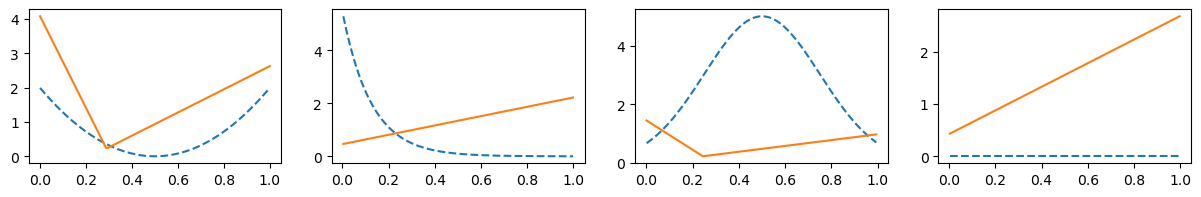

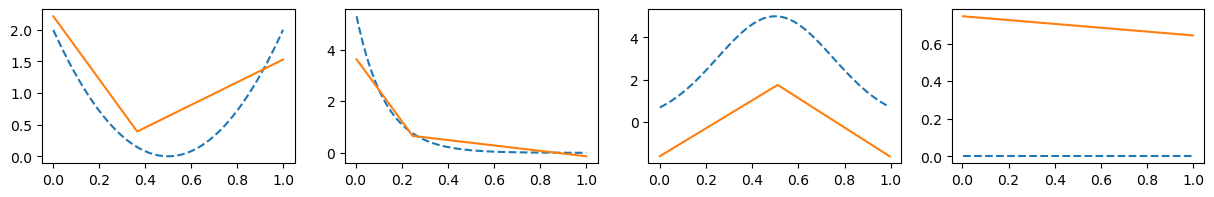

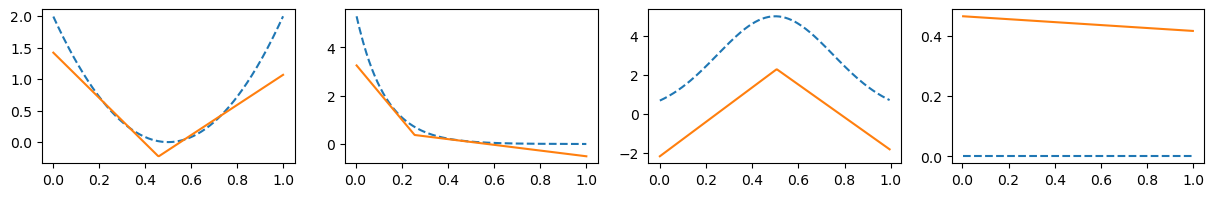

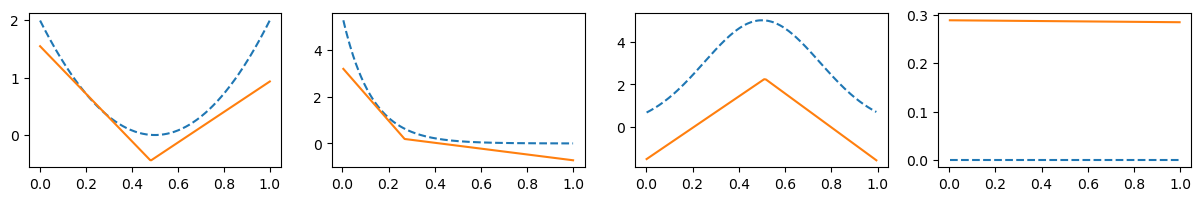

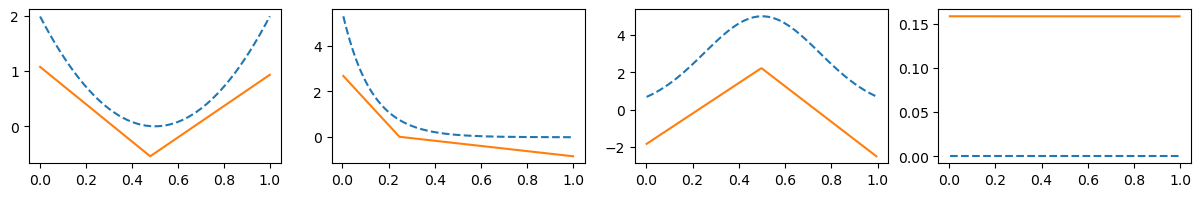

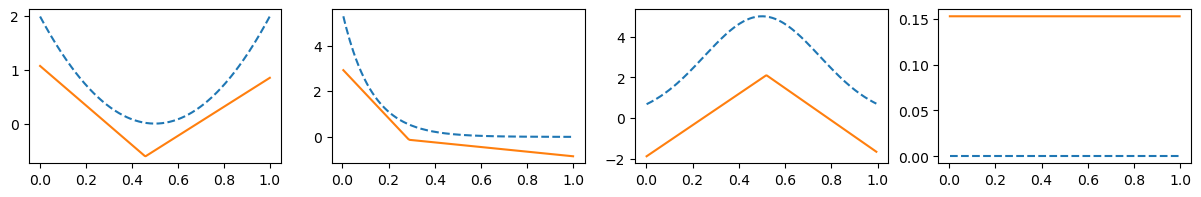

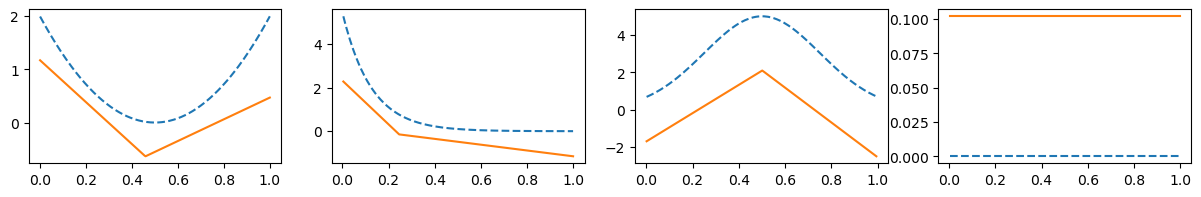

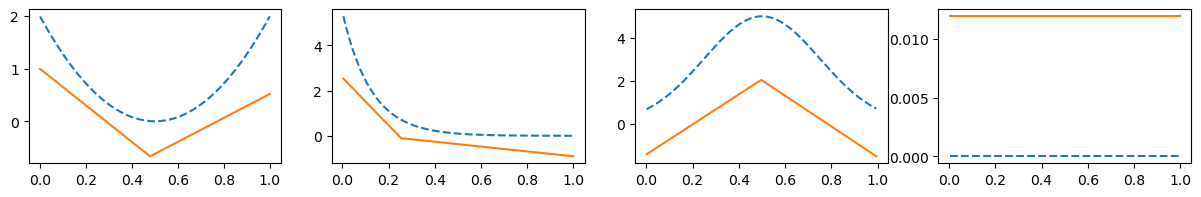

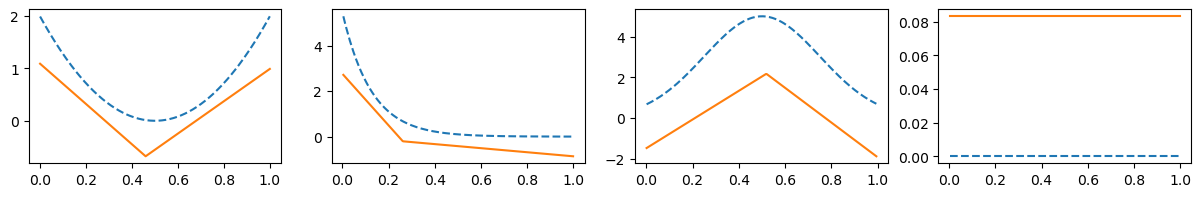

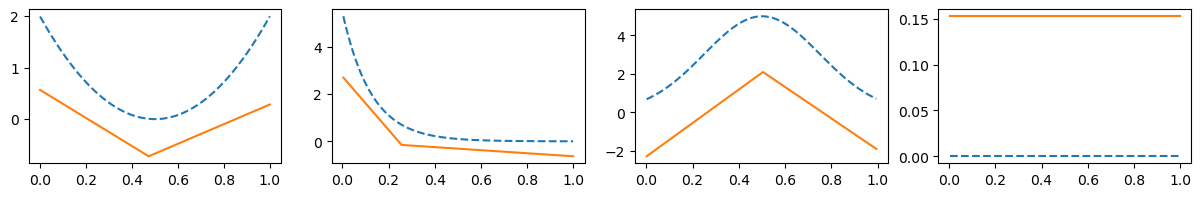

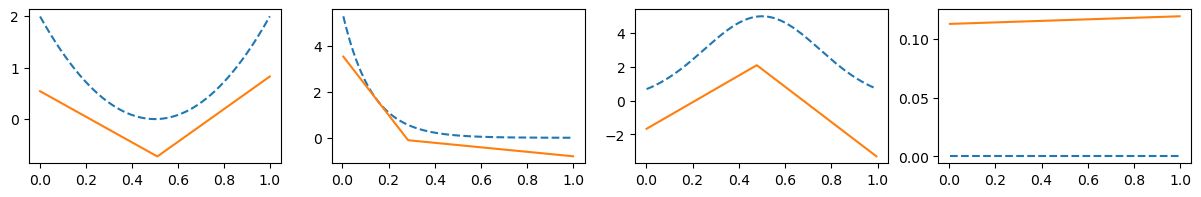

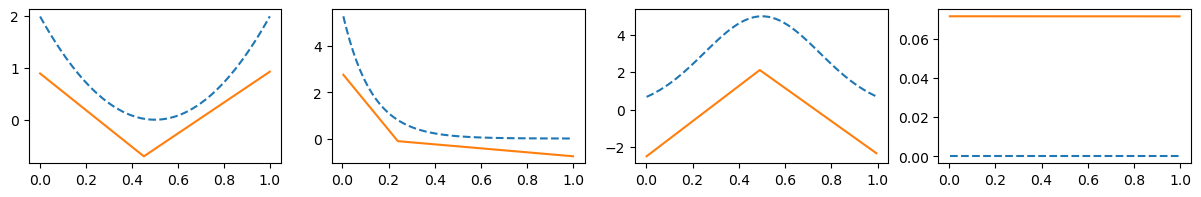

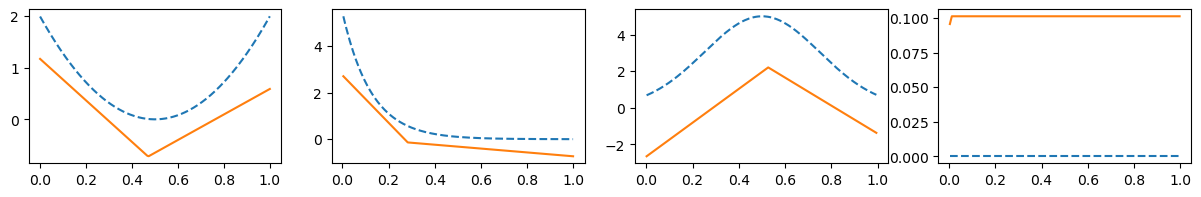

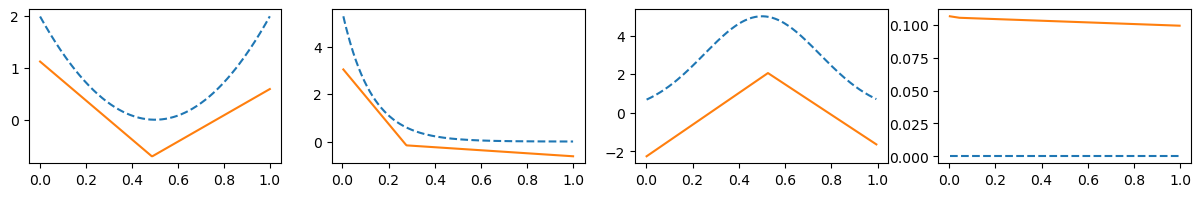

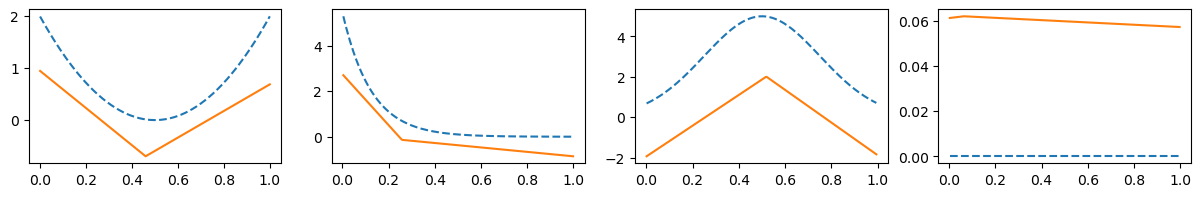

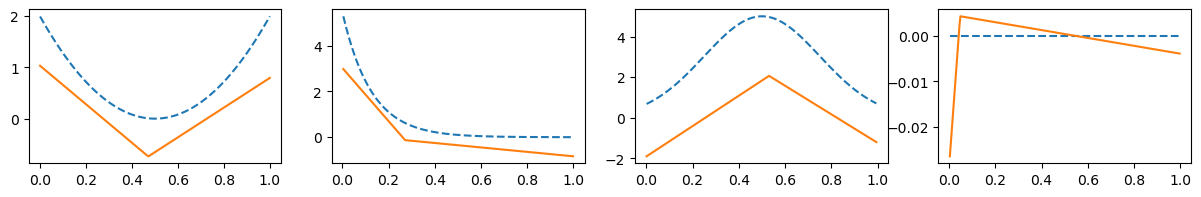

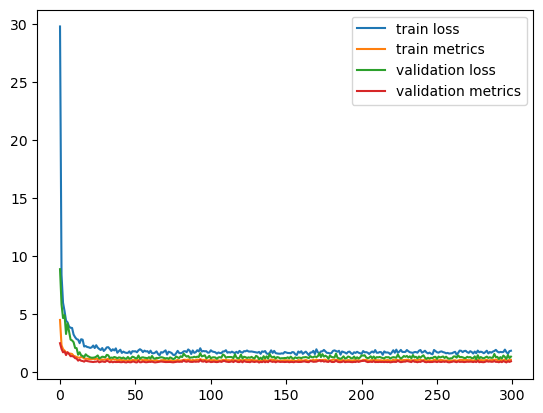

In [13]:
losses_train, metricses_train, losses_val, metricses_val = trainer_best.train()

In [15]:
cfg = Config(regression=True, use_dnn=False, num_epochs=50, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.01643647540674173, l2_regularization=1.2501070474848372e-06, output_regularization=0.002527277205782082, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu') 
cfg.num_epochs = 300
model = NAM(
    config=cfg, 
    name="NAM_BEST", 
    in_features=len(toydataset[0][0]), 
    num_units=cfg.num_basis_functions)
print(model)
trainer_best = Trainer(cfg, model, toydataset, testset)   
print(cfg)

NAM(
  (feature_dropout): Dropout(p=0, inplace=False)
  (feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): ExU(in_features=1, out_features=64)
        (1): Dropout(p=0.05, inplace=False)
        (2): LinearReLU(in_features=64, out_features=64)
        (3): Dropout(p=0.05, inplace=False)
        (4): LinearReLU(in_features=64, out_features=32)
        (5): Dropout(p=0.05, inplace=False)
        (6): Linear(in_features=32, out_features=1, bias=True)
        (7): Dropout(p=0.05, inplace=False)
      )
    )
  )
)
Config(regression=True, use_dnn=False, num_epochs=300, batch_size=64, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='output', wandb=False, log_loss_frequency=10, lr=0.01643647540674173, l2_regularization=1.2501070474848372e-06, output_regularization=0.002527277205782082, dropout=0.05, feature_dropout=0, num_basis_functions=64, hidden_sizes=[64, 32], activation='exu')


==============EPOCH 0================
loss_train_epoch: 17.412763595581055, MAE_train_epoch: 3.2964720328648887
loss_val_epoch: 8.351304054260254, MAE_val_epoch: 2.2834692001342773
The parameter values:
bias tensor([0.0077])
feature_nns.0.model.0.weights tensor([[3.3446, 4.6147, 3.7398, 3.9287, 3.3397, 3.8924, 4.0084, 3.3620, 4.1042,
         4.1130, 4.1460, 4.0336, 4.7164, 3.9466, 3.7274, 4.2635, 3.6776, 3.6229,
         3.6522, 3.1537, 4.3086, 4.3847, 3.8342, 3.0590, 3.6703, 4.2608, 3.8432,
         4.7772, 3.8835, 3.8035, 2.9963, 4.5186, 4.4294, 4.0549, 3.9526, 3.0068,
         3.5474, 4.2581, 3.4754, 3.5204, 3.9857, 4.0631, 3.9317, 3.4687, 4.4697,
         4.0719, 3.6492, 4.4640, 4.7571, 4.0314, 3.8216, 4.7601, 3.5170, 4.0924,
         3.8484, 3.7984, 3.7426, 2.8788, 4.1274, 3.4885, 3.6223, 4.2373, 4.2305,
         3.3971]])
feature_nns.0.model.0.bias tensor([0.4820])
feature_nns.0.model.2.weights tensor([[ 0.1109, -0.0268,  0.1416,  ..., -0.0037, -0.0344,  0.0398],
        [-0.153

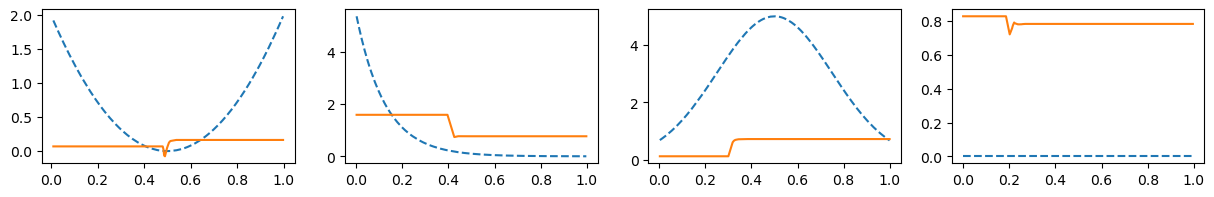

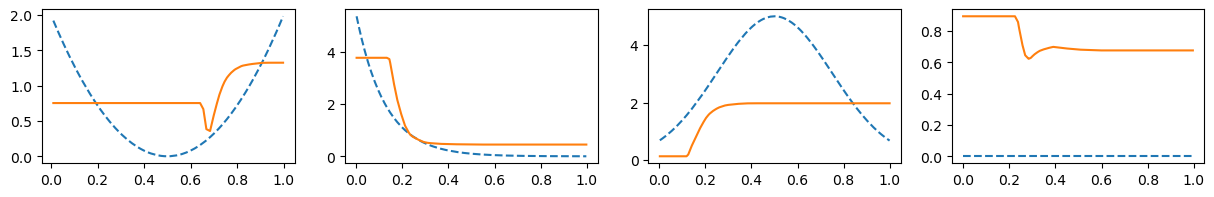

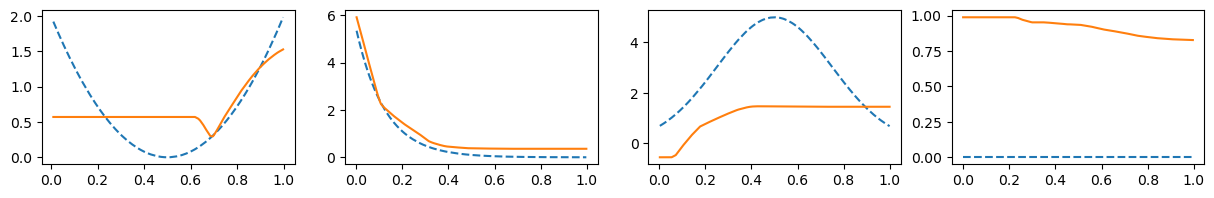

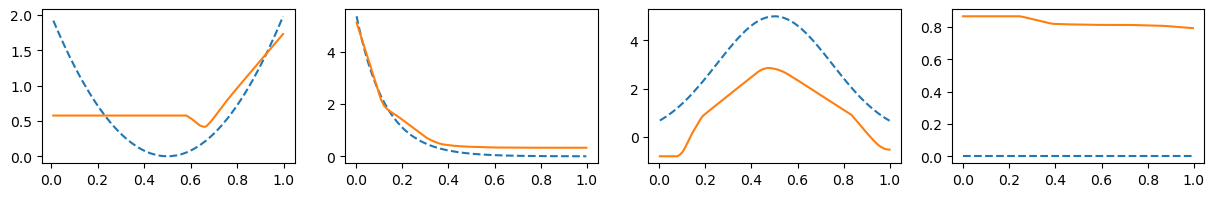

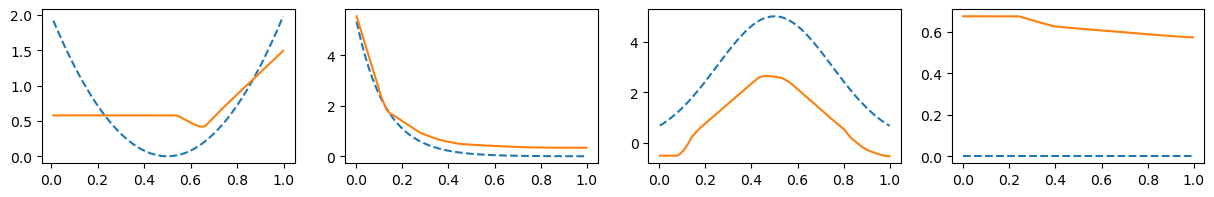

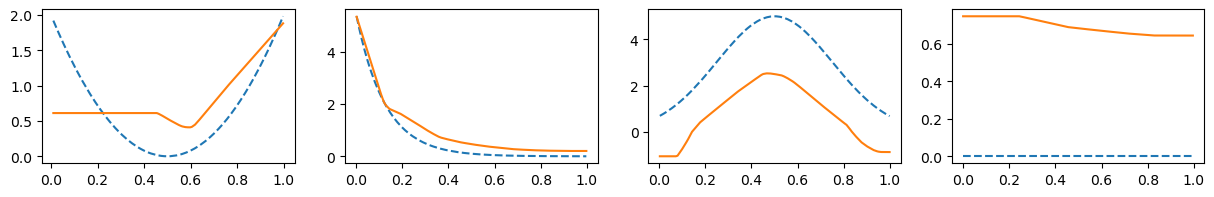

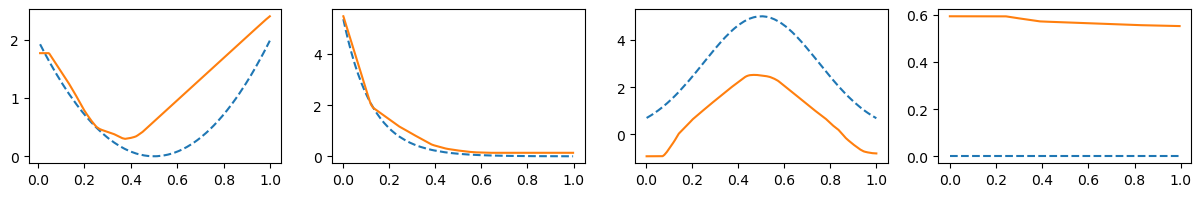

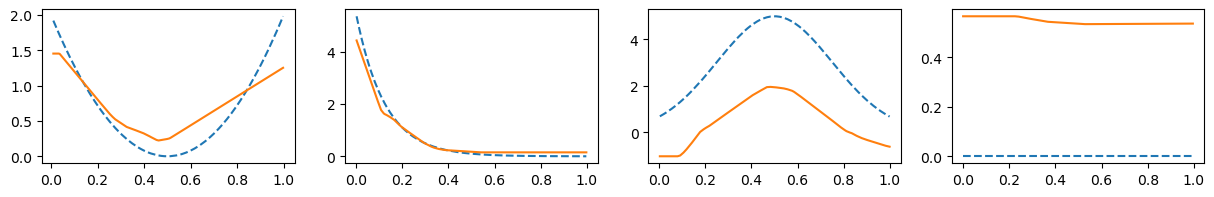

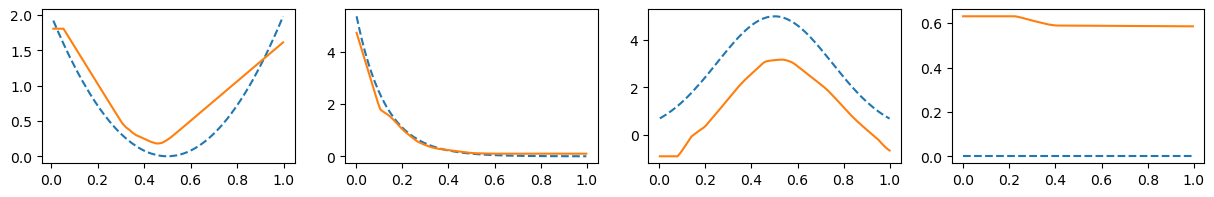

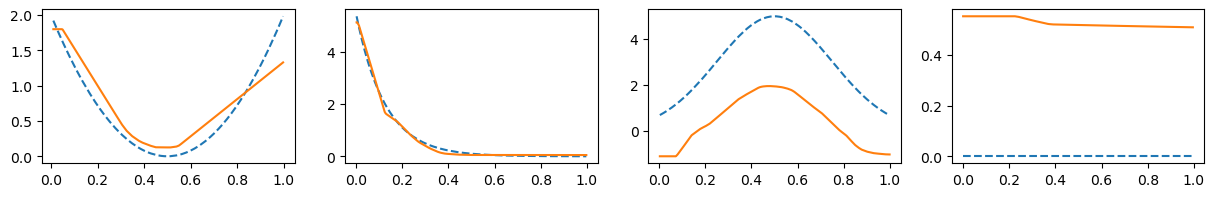

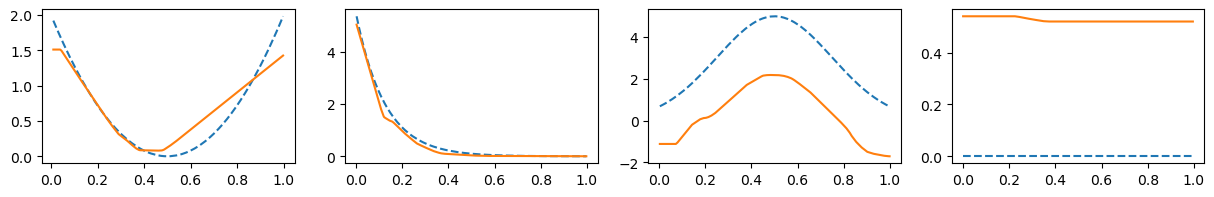

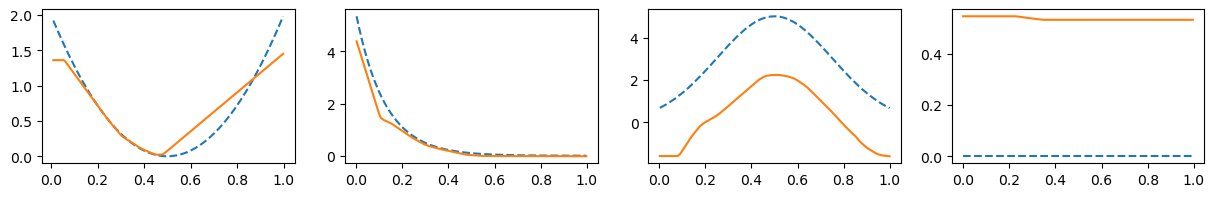

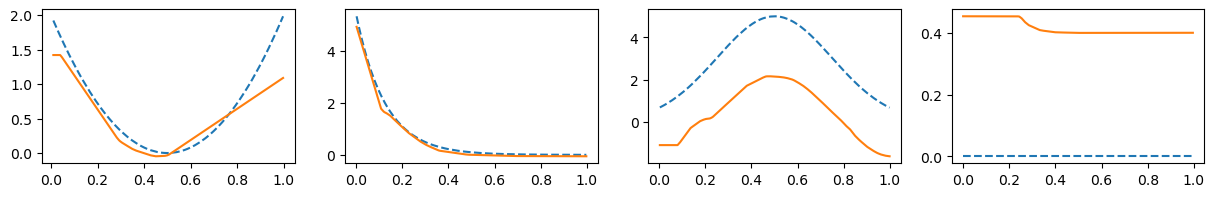

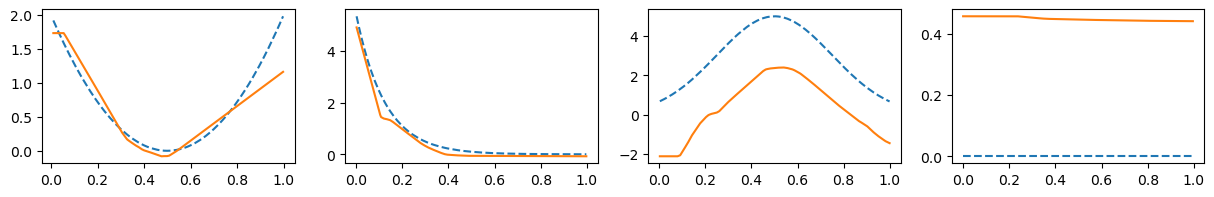

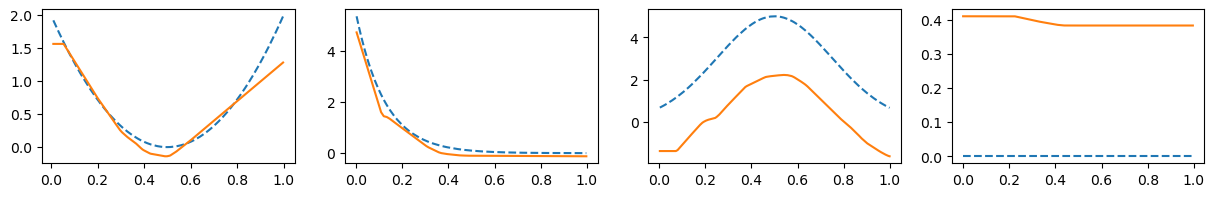

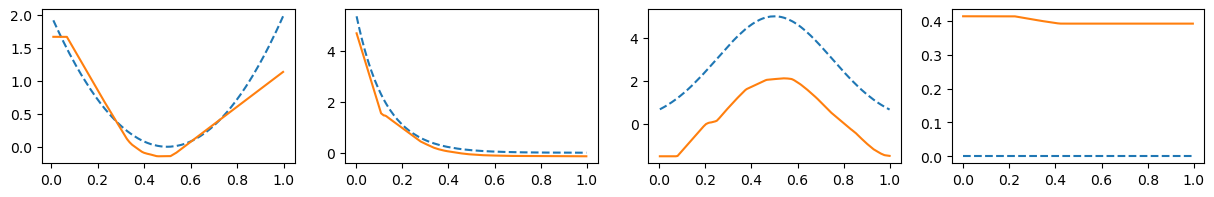

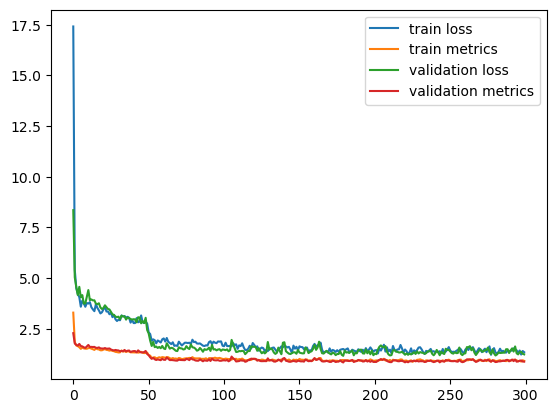

In [16]:
losses_train, metricses_train, losses_val, metricses_val = trainer_best.train()

In [9]:
print("The parameter values:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

bias tensor([2.4846])
feature_nns.0.model.0.weights tensor([[-0.0677, -0.1083, -0.0800, -0.0893, -0.1293, -0.0920, -0.1225, -0.0394,
         -0.0944, -0.1316, -0.0839, -0.0887, -0.0959, -0.1224, -0.0867, -0.0844,
         -0.0813, -0.1004, -0.0834, -0.0567, -0.0702, -0.1137, -0.1306, -0.0822,
         -0.1203, -0.1006, -0.0993, -0.1172, -0.1401, -0.0966, -0.0818, -0.1035,
         -0.0702, -0.1154, -0.1003, -0.1233, -0.1188, -0.1141, -0.1333, -0.1030,
         -0.1037, -0.1337, -0.0963, -0.0989, -0.0937, -0.0810, -0.1212, -0.0917,
         -0.1243, -0.1144, -0.1256, -0.1083, -0.1041, -0.1292, -0.0840, -0.0897,
         -0.1228, -0.1403, -0.1300, -0.0962, -0.0939, -0.1335, -0.1028, -0.1397]])
feature_nns.0.model.0.bias tensor([0.0390])
feature_nns.0.model.2.weights tensor([[ 2.9543e-02, -4.5633e-04, -1.4296e-03,  ..., -5.2927e-04,
         -2.2040e-05, -9.5728e-02],
        [ 1.2474e-01, -3.7278e-04,  2.0597e-03,  ..., -9.8530e-04,
          4.8682e-05, -7.5542e-02],
        [ 8.6570e-

In [ ]:
plot_preds(testdataset, model, cfg.num_epochs)